In [44]:
from src.datasets import MultiDomainDataset, DomainRole
from src.models import prep_resnet50
from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch

In [5]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
roles = [DomainRole.TARGET, DomainRole.TARGET, DomainRole.TARGET, DomainRole.TARGET]

dataset = MultiDomainDataset(
    root="../data/PACS/",
    domains=domains,
    roles=roles,
    transforms=[None] * len(domains),
    seed=0,
    split_ratio=0.80,
)

In [58]:
samples = {}

loaders = dataset.build_target_dataloaders()

for domain, loader in zip(domains, loaders):
    samples_per_domain = {}
    for batch in loader:
        _, x, y = batch
        if y.item() not in samples_per_domain:
            samples_per_domain[y.item()] = x
    assert len(samples_per_domain) == 7
    samples[domain] = samples_per_domain

In [66]:
flat_samples = [
    x.squeeze().to(torch.float32)
    for domain, samples_per_domain in samples.items()
    for label, x in samples_per_domain.items()
]
len(flat_samples), flat_samples[0].shape, flat_samples[0].dtype

(28, torch.Size([3, 227, 227]), torch.float32)

torch.Size([3, 918, 1605])


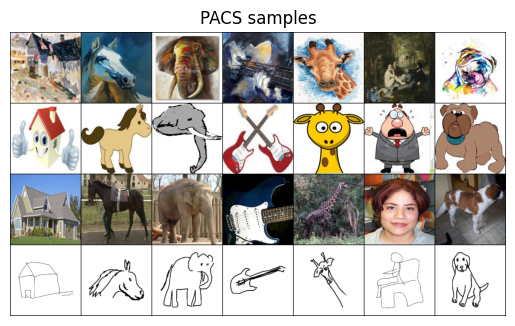

In [75]:
grid = make_grid(flat_samples, nrow=7, normalize=True)
print(grid.shape)
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis("off")
plt.title("PACS samples")
plt.savefig("PACSSamples.jpg", dpi=1024, bbox_inches="tight")
plt.show()

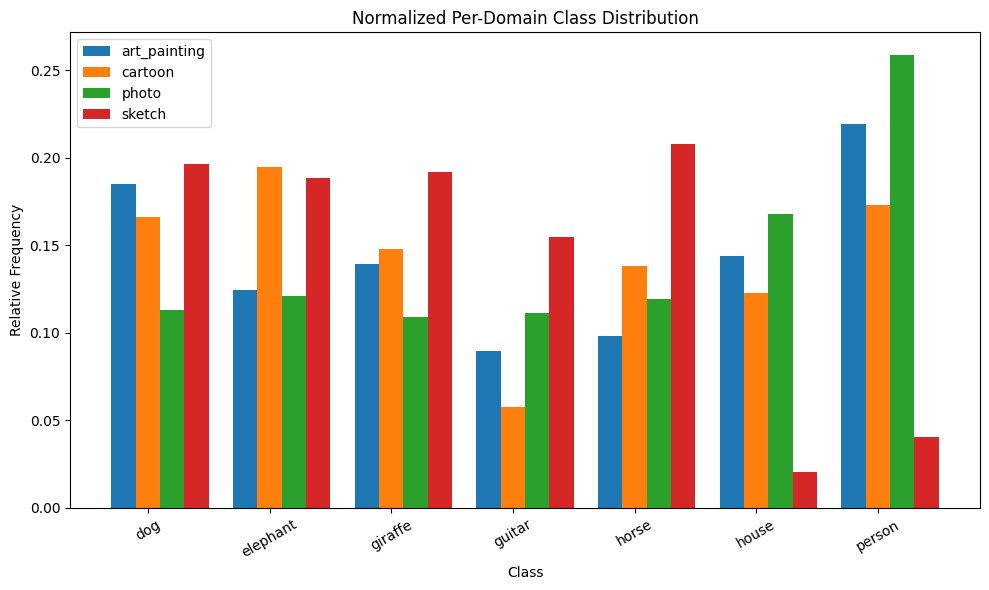

In [79]:
from collections import Counter

# Count class occurrences per domain using Counter
class_counts = {}

loaders = dataset.build_target_dataloaders()

for domain, loader in zip(domains, loaders):
    counter = Counter()
    for batch in loader:
        _, _, y = batch
        counter.update(y.tolist())  # Convert tensor to list of ints
    class_counts[domain] = counter

# Determine global class set
all_classes = sorted(set(cls for counter in class_counts.values() for cls in counter))

# Plotting
width = 0.8 / len(class_counts)  # adjust bar width for overlap

plt.figure(figsize=(10, 6))

for i, (domain, counter) in enumerate(class_counts.items()):
    total = sum(counter.values())
    rel_freqs = [counter.get(c, 0) / total for c in all_classes]
    x = [c + i * width for c in all_classes]
    plt.bar(x, rel_freqs, width=width, label=domain)

idx_to_class = {
    v: k for k, v in dataset.datasets[0].class_to_idx.items()
}

plt.xlabel("Class")
plt.ylabel("Relative Frequency")
plt.title("Normalized Per-Domain Class Distribution")
plt.xticks([c + width for c in all_classes], [idx_to_class[i] for i in all_classes], rotation=30)
plt.legend()
plt.tight_layout()
plt.savefig("PACSDistribution.jpg", dpi=1024, bbox_inches="tight")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def prep_resnet50():
    from torchvision.models import resnet50, ResNet50_Weights
    encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
    encoder.fc = nn.Identity()  # Remove the final FC layer
    return encoder

def generate_embeddings(model, loaders, device, domains, transform):
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_domains = []

    with torch.no_grad():
        for domain, loader in zip(domains, loaders):
            for _, x, y in tqdm(loader, desc="Generating embeddings", total=len(loader)):
                x = x.to(device)
                x = transform(x)
                embeddings = model(x)  # Forward pass through the model
                all_embeddings.append(embeddings.cpu().numpy())  # Store embeddings
                all_domains.append([domain] * len(x))  # Store domain labels for each sample

    # Stack all embeddings and domain labels
    all_embeddings = np.vstack(all_embeddings)
    all_domains = np.concatenate(all_domains)
    return all_embeddings, all_domains


# # Define the necessary transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet50 mean/std normalization
# ])

transform = ResNet50_Weights.IMAGENET1K_V2.transforms()

# Example dataloaders list and domain names (replace with your actual dataloaders and domain names)
domains = dataset.domains

# Load the ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = prep_resnet50().to(device)

# Get the embeddings and domains
embeddings, domains = generate_embeddings(model, loaders, device, domains, transform)


In [99]:

def visualize_tsne(embeddings, domains, num_domains):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    # Generate colors for each domain
    unique_domains = np.unique(domains)
    # domain_colors = plt.cm.get_cmap('tab10', num_domains)
    domain_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]


    # Plotting
    plt.figure(figsize=(10, 8))
    for i, domain in tqdm(enumerate(unique_domains), desc="Visualizing tsne", total=len(unique_domains)):
        domain_indices = domains == domain
        plt.scatter(tsne_results[domain_indices, 0], tsne_results[domain_indices, 1],
                    label=f'{domain}',
                    color=domain_colors[i], alpha=0.6)

    plt.legend()
    plt.title('t-SNE Visualization of ResNet50 Embeddings by Domain')
    plt.savefig("PACSFeatures.jpg", dpi=1024, bbox_inches="tight")
    plt.show()

Visualizing tsne: 100%|██████████| 4/4 [00:00<00:00, 411.26it/s]


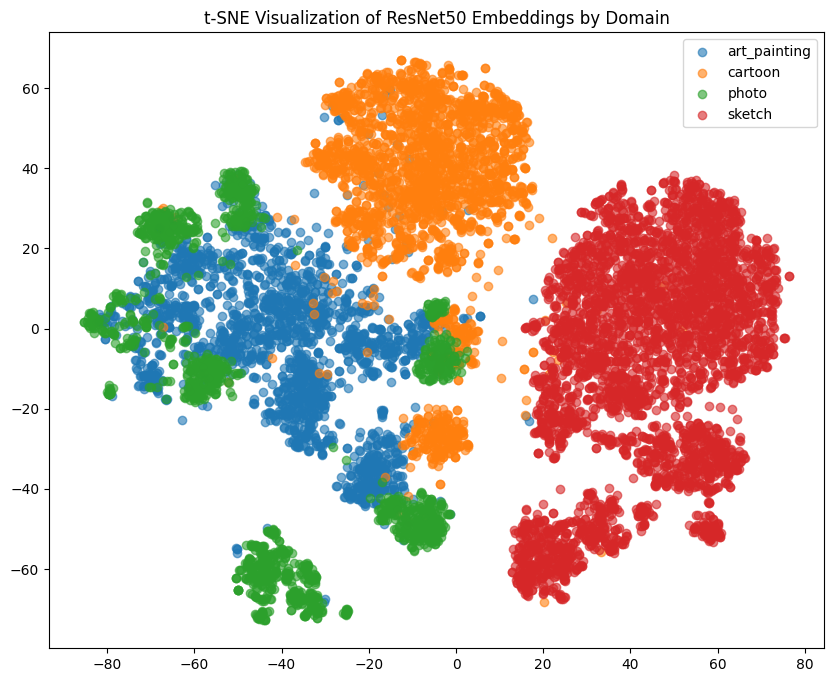

In [100]:
# Visualize the embeddings using t-SNE by domain
visualize_tsne(embeddings, domains, num_domains=len(domains))